# Step1 安装依赖

In [ ]:
!pip uninstall -y parl  # 说明：AIStudio预装的parl版本太老，容易跟其他库产生兼容性冲突，建议先卸载
!pip uninstall -y pandas scikit-learn # 提示：在AIStudio中卸载这两个库再import parl可避免warning提示，不卸载也不影响parl的使用
!pip uninstall -y paddlepaddle

!pip install gym
!pip install paddlepaddle==1.6.3
!pip install parl==1.3.1

# 说明：安装日志中出现两条红色的关于 paddlehub 和 visualdl 的 ERROR 与parl无关，可以忽略，不影响使用

Uninstalling parl-1.1.2:
  Successfully uninstalled parl-1.1.2
Uninstalling pandas-0.23.4:
  Successfully uninstalled pandas-0.23.4
Uninstalling scikit-learn-0.20.0:
  Successfully uninstalled scikit-learn-0.20.0
Uninstalling paddlepaddle-1.7.1:
  Successfully uninstalled paddlepaddle-1.7.1
Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
     |████████████████████████████████| 90.9MB 314kB/s eta 0:00:016
Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
     |████████████████████████████████| 522kB 3.2MB/s eta 0:00:01
     |████████████████████████████████| 450kB 3.9MB/s eta 0:00:01
     |████████████████████████████████| 2.9MB 75kB/s eta 0:00:011
     |████████████████████████████████| 51kB 7.2MB/s eta 0:00:011
     |████████████████████████████████| 2.1MB 2.6MB/s eta 0:00:01
     |████████████████████████████████| 8.6MB 95kB/s eta 0:00:011
  Created wheel for psutil: filename=psutil-5.7.0-cp37-cp37m-

# Step2  导入依赖

In [9]:
import parl
from parl import layers
import paddle.fluid as fluid
import copy
import numpy as np
import os
import gym
from parl.utils import logger

# Step3 设置超参数

In [19]:
LEARN_FREQ = 5 # 训练频率，不需要每一个step都learn，攒一些新增经验后再learn，提高效率
MEMORY_SIZE = 20000    # replay memory的大小，越大越占用内存
MEMORY_WARMUP_SIZE = 200  # replay_memory 里需要预存一些经验数据，再从里面sample一个batch的经验让agent去learn
BATCH_SIZE = 32   # 每次给agent learn的数据数量，从replay memory随机里sample一批数据出来
GAMMA = 0.995 # reward 的衰减因子，一般取 0.9 到 0.999 不等，本问题步数较多，贴现率应该高点
######################################################################
######################################################################
#
# 1. 请设定 learning rate，可以从 0.001 起调，尝试增减
#
######################################################################
######################################################################
LEARNING_RATE = 0.0025 # 学习率

e_greed=0.1
e_greed_decrement=1e-7

# Step4 搭建Model、Algorithm、Agent架构
* `Agent`把产生的数据传给`algorithm`，`algorithm`根据`model`的模型结构计算出`Loss`，使用`SGD`或者其他优化器不断的优化，`PARL`架构可以很方便的应用在各类深度强化学习问题中。

## Model
* `Model`用来定义前向(`Forward`)网络，用户可以自由的定制自己的网络结构。

In [11]:
class Model(parl.Model):
    def __init__(self, act_dim):
        ######################################################################
        ######################################################################
        #
        # 2. 请参考课堂Demo，配置model
        #
        ######################################################################
        ######################################################################
        hid1_size = 64
        hid2_size = 64
        # hid3_size = 64
        # self.hidden_layers = [hid1_size, hid2_size, hid3_size]
        self.hidden_layers = [hid1_size, hid2_size]
        # 4层
        self.fc1 = layers.fc(size=hid1_size, act='relu')
        self.fc2 = layers.fc(size=hid2_size, act='relu')
        # self.fc3 = layers.fc(size=hid3_size, act='relu')
        # self.fc4 = layers.fc(size=act_dim, act=None)
        self.fc3 = layers.fc(size=act_dim, act=None)

    def value(self, obs):
        # 定义网络
        # 输入state，输出所有action对应的Q，[Q(s,a1), Q(s,a2), Q(s,a3)...]
        
        ######################################################################
        ######################################################################
        #
        # 3. 请参考课堂Demo，组装Q网络
        #
        ######################################################################
        ######################################################################
        h1 = self.fc1(obs)
        h2 = self.fc2(h1)
        # h3 = self.fc3(h2)
        # Q = self.fc4(h3)
        Q = self.fc3(h2)
        return Q

## Algorithm
* `Algorithm`定义了具体的算法来更新前向网络(`Model`)，也就是通过定义损失函数来更新`Model`，和算法相关的计算都放在`algorithm`中。

In [12]:
from parl.algorithms import DQN # 直接从parl库中导入DQN算法，无需自己重写算法

## Agent
* `Agent`负责算法与环境的交互，在交互过程中把生成的数据提供给`Algorithm`来更新模型(`Model`)，数据的预处理流程也一般定义在这里。

In [13]:
class Agent(parl.Agent):
    def __init__(self,
                 algorithm,
                 obs_dim,
                 act_dim,
                 e_greed=0.1,
                 e_greed_decrement=0):
        assert isinstance(obs_dim, int)
        assert isinstance(act_dim, int)
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        super(Agent, self).__init__(algorithm)

        self.global_step = 0
        self.update_target_steps = 200  # 每隔200个training steps再把model的参数复制到target_model中

        self.e_greed = e_greed  # 有一定概率随机选取动作，探索
        self.e_greed_decrement = e_greed_decrement  # 随着训练逐步收敛，探索的程度慢慢降低

    def build_program(self):
        self.pred_program = fluid.Program()
        self.learn_program = fluid.Program()

        with fluid.program_guard(self.pred_program):  # 搭建计算图用于 预测动作，定义输入输出变量
            obs = layers.data(
                name='obs', shape=[self.obs_dim], dtype='float32')
            self.value = self.alg.predict(obs)

        with fluid.program_guard(self.learn_program):  # 搭建计算图用于 更新Q网络，定义输入输出变量
            obs = layers.data(
                name='obs', shape=[self.obs_dim], dtype='float32')
            action = layers.data(name='act', shape=[1], dtype='int32')
            reward = layers.data(name='reward', shape=[], dtype='float32')
            next_obs = layers.data(
                name='next_obs', shape=[self.obs_dim], dtype='float32')
            terminal = layers.data(name='terminal', shape=[], dtype='bool')
            self.cost = self.alg.learn(obs, action, reward, next_obs, terminal)

    def sample(self, obs):
        sample = np.random.rand()  # 产生0~1之间的小数
        if sample < self.e_greed:
            act = np.random.randint(self.act_dim)  # 探索：每个动作都有概率被选择
        else:
            act = self.predict(obs)  # 选择最优动作
        self.e_greed = max(
            0.01, self.e_greed - self.e_greed_decrement)  # 随着训练逐步收敛，探索的程度慢慢降低
        return act

    def predict(self, obs):  # 选择最优动作
        obs = np.expand_dims(obs, axis=0)
        pred_Q = self.fluid_executor.run(
            self.pred_program,
            feed={'obs': obs.astype('float32')},
            fetch_list=[self.value])[0]
        pred_Q = np.squeeze(pred_Q, axis=0)
        act = np.argmax(pred_Q)  # 选择Q最大的下标，即对应的动作
        return act

    def learn(self, obs, act, reward, next_obs, terminal):
        # 每隔200个training steps同步一次model和target_model的参数
        if self.global_step % self.update_target_steps == 0:
            self.alg.sync_target()
        self.global_step += 1

        act = np.expand_dims(act, -1)
        feed = {
            'obs': obs.astype('float32'),
            'act': act.astype('int32'),
            'reward': reward,
            'next_obs': next_obs.astype('float32'),
            'terminal': terminal
        }
        cost = self.fluid_executor.run(
            self.learn_program, feed=feed, fetch_list=[self.cost])[0]  # 训练一次网络
        return cost

# Step5 ReplayMemory
* 经验池：用于存储多条经验，实现 经验回放。

In [14]:
# replay_memory.py
import random
import collections
import numpy as np


class ReplayMemory(object):
    def __init__(self, max_size):
        self.buffer = collections.deque(maxlen=max_size)

    # 增加一条经验到经验池中
    def append(self, exp):
        self.buffer.append(exp)

    # 从经验池中选取N条经验出来
    def sample(self, batch_size):
        mini_batch = random.sample(self.buffer, batch_size)
        obs_batch, action_batch, reward_batch, next_obs_batch, done_batch = [], [], [], [], []

        for experience in mini_batch:
            s, a, r, s_p, done = experience
            obs_batch.append(s)
            action_batch.append(a)
            reward_batch.append(r)
            next_obs_batch.append(s_p)
            done_batch.append(done)

        return np.array(obs_batch).astype('float32'), \
            np.array(action_batch).astype('float32'), np.array(reward_batch).astype('float32'),\
            np.array(next_obs_batch).astype('float32'), np.array(done_batch).astype('float32')

    def __len__(self):
        return len(self.buffer)


# Step6 Training && Test（训练&&测试）

In [15]:
# 训练一个episode
def run_episode(env, agent, rpm):
    total_reward = 0
    obs = env.reset()
    step = 0
    while True:
        step += 1
        action = agent.sample(obs)  # 采样动作，所有动作都有概率被尝试到
        next_obs, reward, done, _ = env.step(action)
        rpm.append((obs, action, reward, next_obs, done))

        # train model
        if (len(rpm) > MEMORY_WARMUP_SIZE) and (step % LEARN_FREQ == 0):
            (batch_obs, batch_action, batch_reward, batch_next_obs,
             batch_done) = rpm.sample(BATCH_SIZE)
            train_loss = agent.learn(batch_obs, batch_action, batch_reward,
                                     batch_next_obs,
                                     batch_done)  # s,a,r,s',done

        total_reward += reward
        obs = next_obs
        if done:
            break
    return total_reward


# 评估 agent, 跑 5 个episode，总reward求平均
def evaluate(env, agent, render=False):
    eval_reward = []
    for i in range(5):
        obs = env.reset()
        episode_reward = 0
        while True:
            action = agent.predict(obs)  # 预测动作，只选最优动作
            obs, reward, done, _ = env.step(action)
            episode_reward += reward
            if render:
                env.render()
            if done:
                break
        eval_reward.append(episode_reward)
    return np.mean(eval_reward)


# Step7 创建环境和Agent，创建经验池，启动训练，保存模型

In [20]:
# 创建环境
env = gym.make('MountainCar-v0')
action_dim = env.action_space.n  # MountainCar-v0: 3
obs_shape = env.observation_space.shape  # MountainCar-v0: (2,)

# 创建经验池
rpm = ReplayMemory(MEMORY_SIZE)  # DQN的经验回放池



# 根据parl框架构建agent
######################################################################
######################################################################
#
# 4. 请参考课堂Demo，嵌套Model, DQN, Agent构建 agent
#
######################################################################
######################################################################
model = Model(act_dim=action_dim)
algorithm = DQN(model, act_dim=action_dim, gamma=GAMMA, lr=LEARNING_RATE)
agent = Agent(algorithm, obs_dim=obs_shape[0], act_dim=action_dim, e_greed=e_greed, e_greed_decrement=e_greed_decrement)


# 加载模型
# save_path = './dqn_model.ckpt'
# agent.restore(save_path)

# 先往经验池里存一些数据，避免最开始训练的时候样本丰富度不够
while len(rpm) < MEMORY_WARMUP_SIZE:
    run_episode(env, agent, rpm)

max_episode = 2000

logger.info(f'model_hidden_lay={model.hidden_layers}, LEARNING_RATE={LEARNING_RATE}, GAMMA={GAMMA}, MEMORY_SIZE={MEMORY_SIZE}, e_greed_decrement={e_greed_decrement}, \
e_greed={e_greed}, max_episode={max_episode}, LEARN_FREQ={LEARN_FREQ}, MEMORY_WARMUP_SIZE={MEMORY_WARMUP_SIZE}, BATCH_SIZE={BATCH_SIZE}')

# 开始训练
episode = 0
train_score_list = []  # 记录所有分数
test_score_list = []
while episode < max_episode:  # 训练max_episode个回合，test部分不计算入episode数量
    # train part
    for i in range(0, 50):
        total_reward = run_episode(env, agent, rpm)
        episode += 1
    train_score_list.append(total_reward)  # 每50轮记录一次训练分数

    # test part
    eval_reward = evaluate(env, agent, render=False)  # render=True 查看显示效果
    test_score_list.append(eval_reward)    # 每50轮记录一次测试分数
    logger.info('episode:{}    e_greed:{}   test_reward:{}'.format(
        episode, agent.e_greed, eval_reward))

# 训练结束，保存模型
save_path = './dqn_model.ckpt'
agent.save(save_path)

[06-18 19:48:07 MainThread @machine_info.py:88] Cannot find available GPU devices, using CPU now.
[06-18 19:48:07 MainThread @machine_info.py:88] Cannot find available GPU devices, using CPU now.
[06-18 19:48:08 MainThread @<ipython-input-20-d8311c7646f9>:35] model_hidden_lay=[64, 64], LEARNING_RATE=0.0025, GAMMA=0.995, MEMORY_SIZE=20000, e_greed_decrement=1e-07, e_greed=0.1, max_episode=2000, LEARN_FREQ=5, MEMORY_WARMUP_SIZE=200, BATCH_SIZE=32
[06-18 19:48:08 MainThread @machine_info.py:88] Cannot find available GPU devices, using CPU now.
[06-18 19:48:48 MainThread @<ipython-input-20-d8311c7646f9>:52] episode:50    e_greed:0.09898389999997079   test_reward:-200.0
[06-18 19:49:34 MainThread @<ipython-input-20-d8311c7646f9>:52] episode:100    e_greed:0.0979861999999421   test_reward:-200.0
[06-18 19:50:19 MainThread @<ipython-input-20-d8311c7646f9>:52] episode:150    e_greed:0.0969880999999134   test_reward:-200.0
[06-18 19:51:05 MainThread @<ipython-input-20-d8311c7646f9>:52] episode:

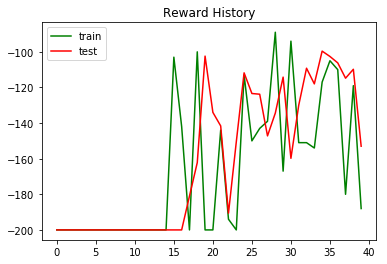

In [21]:
# 画出训练过程train和test reward历史曲线
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_score_list, color='green', label='train')
plt.plot(test_score_list, color='red', label='test')
plt.title('Reward History')
plt.legend()
plt.show()

[06-18 20:13:20 MainThread @<ipython-input-22-c21ef8df243d>:22] episode:2000    e_greed:0.06694229999904941   test_reward:-112.23


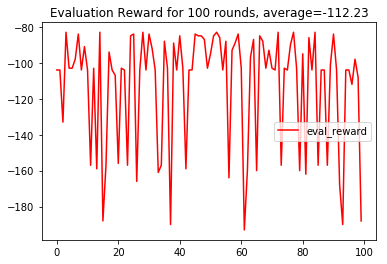

In [22]:
# final test 
# 评估 agent, 跑 100 个episode，总reward求平均
def evaluate_final(env, agent, render=False, cnt_run=100):
    eval_reward = []
    for i in range(cnt_run):
        obs = env.reset()
        episode_reward = 0
        while True:
            action = agent.predict(obs)  # 预测动作，只选最优动作
            obs, reward, done, _ = env.step(action)
            episode_reward += reward
            if render:
                env.render()
            if done:
                break
        eval_reward.append(episode_reward)
    return eval_reward

cnt_run = 100
eval_reward = evaluate_final(env, agent, render=False, cnt_run=cnt_run)  # render=True 查看显示效果 
logger.info('episode:{}    e_greed:{}   test_reward:{}'.format(
    episode, agent.e_greed, np.mean(eval_reward)))

plt.plot(eval_reward, color='red', label='eval_reward') 
plt.title(f'Evaluation Reward for {cnt_run} rounds, average={np.mean(eval_reward)}')
plt.legend()
plt.show()

In [23]:
class Model(parl.Model):
    def __init__(self, act_dim):
        # 3层隐藏层
        hid1_size = 24
        hid2_size = 48
        hid3_size = 24
        self.hidden_layers = [hid1_size, hid2_size, hid3_size]
        # 4层
        self.fc1 = layers.fc(size=hid1_size, act='relu')
        self.fc2 = layers.fc(size=hid2_size, act='relu') 
        self.fc3 = layers.fc(size=hid3_size, act='relu') 
        self.fc4 = layers.fc(size=act_dim, act=None)

    def value(self, obs):
        # 定义网络
        # 输入state，输出所有action对应的Q，[Q(s,a1), Q(s,a2), Q(s,a3)...] 
        h1 = self.fc1(obs)
        h2 = self.fc2(h1) 
        h3 = self.fc3(h2) 
        Q = self.fc4(h3)
        return Q

In [24]:
# 创建环境
env = gym.make('MountainCar-v0')
action_dim = env.action_space.n  # MountainCar-v0: 3
obs_shape = env.observation_space.shape  # MountainCar-v0: (2,)

# 创建经验池
rpm = ReplayMemory(MEMORY_SIZE)  # DQN的经验回放池

# 根据parl框架构建agent 
model = Model(act_dim=action_dim)
algorithm = DQN(model, act_dim=action_dim, gamma=GAMMA, lr=LEARNING_RATE)
agent = Agent(algorithm, obs_dim=obs_shape[0], act_dim=action_dim, e_greed=e_greed, e_greed_decrement=e_greed_decrement)


# 加载模型
# save_path = './dqn_model.ckpt'
# agent.restore(save_path)

# 先往经验池里存一些数据，避免最开始训练的时候样本丰富度不够
while len(rpm) < MEMORY_WARMUP_SIZE:
    run_episode(env, agent, rpm)

max_episode = 2000

logger.info(f'model_hidden_lay={model.hidden_layers}, LEARNING_RATE={LEARNING_RATE}, GAMMA={GAMMA}, MEMORY_SIZE={MEMORY_SIZE}, e_greed_decrement={e_greed_decrement}, \
e_greed={e_greed}, max_episode={max_episode}, LEARN_FREQ={LEARN_FREQ}, MEMORY_WARMUP_SIZE={MEMORY_WARMUP_SIZE}, BATCH_SIZE={BATCH_SIZE}')

# 开始训练
episode = 0
train_score_list = []  # 记录所有分数
test_score_list = []
while episode < max_episode:  # 训练max_episode个回合，test部分不计算入episode数量
    # train part
    for i in range(0, 50):
        total_reward = run_episode(env, agent, rpm)
        episode += 1
    train_score_list.append(total_reward)  # 每50轮记录一次训练分数

    # test part
    eval_reward = evaluate(env, agent, render=False)  # render=True 查看显示效果
    test_score_list.append(eval_reward)    # 每50轮记录一次测试分数
    logger.info('episode:{}    e_greed:{}   test_reward:{}'.format(
        episode, agent.e_greed, eval_reward))

# 训练结束，保存模型
save_path = './dqn_model_3hidlayers.ckpt'
agent.save(save_path)

[06-18 20:13:20 MainThread @machine_info.py:88] Cannot find available GPU devices, using CPU now.
[06-18 20:13:21 MainThread @machine_info.py:88] Cannot find available GPU devices, using CPU now.
[06-18 20:13:21 MainThread @<ipython-input-24-6e73e61720ec>:26] model_hidden_lay=[24, 48, 24], LEARNING_RATE=0.0025, GAMMA=0.995, MEMORY_SIZE=20000, e_greed_decrement=1e-07, e_greed=0.1, max_episode=2000, LEARN_FREQ=5, MEMORY_WARMUP_SIZE=200, BATCH_SIZE=32
[06-18 20:13:21 MainThread @machine_info.py:88] Cannot find available GPU devices, using CPU now.
[06-18 20:14:08 MainThread @<ipython-input-24-6e73e61720ec>:43] episode:50    e_greed:0.09897999999997067   test_reward:-200.0
[06-18 20:14:57 MainThread @<ipython-input-24-6e73e61720ec>:43] episode:100    e_greed:0.09798689999994212   test_reward:-200.0
[06-18 20:15:47 MainThread @<ipython-input-24-6e73e61720ec>:43] episode:150    e_greed:0.09698699999991336   test_reward:-200.0
[06-18 20:16:36 MainThread @<ipython-input-24-6e73e61720ec>:43] ep

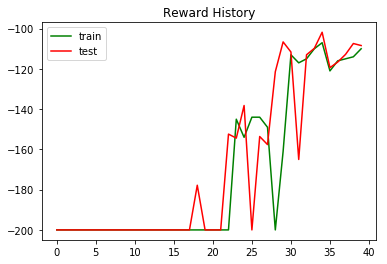

In [25]:
# 画出训练过程train和test reward历史曲线
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_score_list, color='green', label='train')
plt.plot(test_score_list, color='red', label='test')
plt.title('Reward History')
plt.legend()
plt.show()

[06-18 20:42:01 MainThread @<ipython-input-26-c21ef8df243d>:22] episode:2000    e_greed:0.06563359999901178   test_reward:-108.58


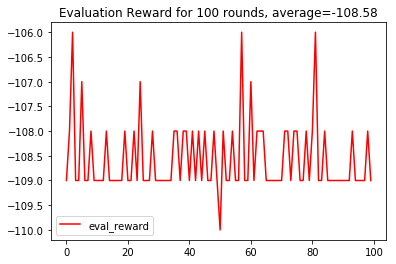

In [26]:
# final test 
# 评估 agent, 跑 100 个episode，总reward求平均
def evaluate_final(env, agent, render=False, cnt_run=100):
    eval_reward = []
    for i in range(cnt_run):
        obs = env.reset()
        episode_reward = 0
        while True:
            action = agent.predict(obs)  # 预测动作，只选最优动作
            obs, reward, done, _ = env.step(action)
            episode_reward += reward
            if render:
                env.render()
            if done:
                break
        eval_reward.append(episode_reward)
    return eval_reward

cnt_run = 100
eval_reward = evaluate_final(env, agent, render=False, cnt_run=cnt_run)  # render=True 查看显示效果 
logger.info('episode:{}    e_greed:{}   test_reward:{}'.format(
    episode, agent.e_greed, np.mean(eval_reward)))

plt.plot(eval_reward, color='red', label='eval_reward') 
plt.title(f'Evaluation Reward for {cnt_run} rounds, average={np.mean(eval_reward)}')
plt.legend()
plt.show()

# 小结
主要研究了神经网络结构，学习率，GAMMA，MEMORY_SIZE和e_greed_decrement对结果的影响，主要结论如下：
- MountainCar问题其实并不需要非常复杂的神经网络就可以求解，尝试了2个隐藏层[128, 128], [64, 64], [32, 64]和3个隐藏层[24, 48, 24]的网络都可以达到平均reward>-120；
	- 在我的训练设置下，**3个隐藏层[24, 48, 24]的网络的效果最好**
- 尝试了GAMMA为0.9，0.99和0.995的情况，设置为0.995时训练时reward大于-200更早出现，考虑到这个问题相比CartPole更需要关注远期收益，因此设置**GAMMA=0.995**；
- MEMORY_SIZE理论上讲是越大越好，尝试了20000和5000，感觉都够用；
- e_greed_decrement衰减速度为1e-6时，在episode 1050之后e_greed就稳定在最小值0.01了，为了增加多样性，尝试了**e_greed_decrement=1e-7**，总体感觉比1e-6效果稍好些；
- 学习率非常关键，较大的学习率前期效果明显，后期容易波动，较小的学习率需要非常长的训练时间才能见到效果：
	- 默认的0.001对于CartPole效果不错，但对于MountainCar而言，明显太小，2000个episode下来reward几乎全是-200；
    - 尝试了0.0025和0.005，0.005更早收敛，但是后续波动也明显更大，所以最终选择了**LEARNING_RATE=0.0025**；

> 由于每次实验需要20~30分钟，而AIStudio不能多开实验，所以主要是在本地机器进行实验，本笔记中展示了model_hidden_lay=[64, 64]和model_hidden_lay=[24, 48, 24]两种网络结构的结果；
> 每次重新训练得到的结果还是有一定波动的，但载入模型继续训练则会出现reward先减小再降低达到相对稳定的效果，说明模型在4000个episode还是能基本收敛的.

> 另外，本地机器的结果多数情况下优于AIStudio的结果，两者代码完全一致，软件层面区别是PaddlePaddle版本不一致，本地机器为1.8.2，AIStudio中安装了1.6.3，硬件层面区别不明。
- 本地机器 model_hidden_lay=[24, 48, 24]的部分训练日志和训练完成后100次测试结果：
```
[06-19 01:01:29 MainThread @<ipython-input-8-bdf3b83db0db>:35] model_hidden_lay=[24, 48, 24], LEARNING_RATE=0.0025, GAMMA=0.995, MEMORY_SIZE=5000, e_greed_decrement=1e-07, e_greed=0.1, max_episode=2000, LEARN_FREQ=5, MEMORY_WARMUP_SIZE=200, BATCH_SIZE=32

[06-19 01:24:00 MainThread @<ipython-input-8-bdf3b83db0db>:52] episode:1800    e_greed:0.07145399999917915   test_reward:-109.4
[06-19 01:24:29 MainThread @<ipython-input-8-bdf3b83db0db>:52] episode:1850    e_greed:0.07084169999916154   test_reward:-113.4
[06-19 01:24:56 MainThread @<ipython-input-8-bdf3b83db0db>:52] episode:1900    e_greed:0.0702594999991448   test_reward:-107.6
[06-19 01:25:23 MainThread @<ipython-input-8-bdf3b83db0db>:52] episode:1950    e_greed:0.06969159999912847   test_reward:-107.8
[06-19 01:25:50 MainThread @<ipython-input-8-bdf3b83db0db>:52] episode:2000    e_greed:0.06912539999911219   test_reward:-104.6
```
![](https://ai-studio-static-online.cdn.bcebos.com/cd173cd7c11348b881b9471598990cd376e7c9a4e2834fa091c1a58d10ffd880)
